In [368]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt

/kaggle/input/customer-analytics/Train.csv


In [369]:
df = pd.read_csv("/kaggle/input/customer-analytics/Train.csv")
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [370]:
import warnings
warnings.filterwarnings('ignore')

In [371]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score,GridSearchCV

from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

In [372]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [373]:
df.groupby(["Mode_of_Shipment"])["Weight_in_gms"].count()

Mode_of_Shipment
Flight    1777
Road      1760
Ship      7462
Name: Weight_in_gms, dtype: int64

In [374]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [375]:
df.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [376]:
df.drop("ID",axis = 1,inplace = True)

## If Product importance is high. having higest rating or being delivered on time?

In [377]:
df.groupby(["Product_importance","Reached.on.Time_Y.N"])["Reached.on.Time_Y.N"].count()

Product_importance  Reached.on.Time_Y.N
high                0                       332
                    1                       616
low                 0                      2157
                    1                      3140
medium              0                      1947
                    1                      2807
Name: Reached.on.Time_Y.N, dtype: int64

Mode_of_Shipment  Reached.on.Time_Y.N
Flight            0                       708
                  1                      1069
Road              0                       725
                  1                      1035
Ship              0                      3003
                  1                      4459
Name: Reached.on.Time_Y.N, dtype: int64 


Mode_of_Shipment  Reached.on.Time_Y.N
Flight            0                      0.398424
                  1                      0.601576
Road              0                      0.411932
                  1                      0.588068
Ship              0                      0.402439
                  1                      0.597561
Name: Reached.on.Time_Y.N, dtype: float64


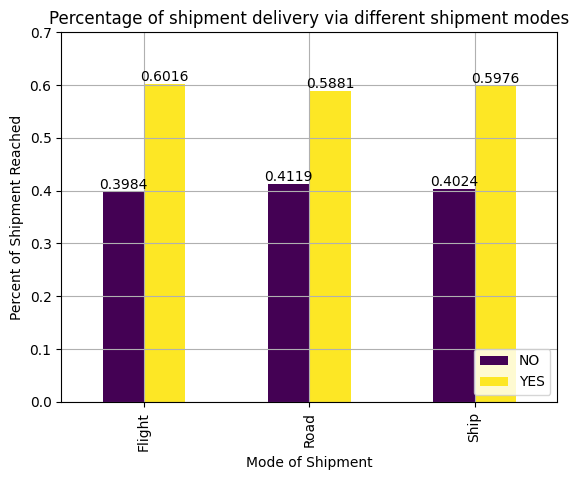

In [378]:
print(df.groupby(["Mode_of_Shipment","Reached.on.Time_Y.N"])["Reached.on.Time_Y.N"].count(),"\n\n")
print(df.groupby(["Mode_of_Shipment","Reached.on.Time_Y.N"])["Reached.on.Time_Y.N"].count()/df.groupby(["Mode_of_Shipment"])["Reached.on.Time_Y.N"].count())


grouped = (df.groupby(["Mode_of_Shipment","Reached.on.Time_Y.N"])["Reached.on.Time_Y.N"].count()/df.groupby(["Mode_of_Shipment"])["Reached.on.Time_Y.N"].count()).unstack(fill_value=0)

# plot the grouped dataframe as a stacked bar chart
ax = grouped.plot(kind='bar', stacked=False,colormap = "viridis")

# set the x-axis label
ax.set_xlabel('Mode of Shipment')

# set the y-axis label
ax.set_ylabel('Percent of Shipment Reached')

plt.legend(labels = ["No","Yes"])

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.yticks([i*0.0001 for i in range(0,8000,1000)])
plt.grid(True)
plt.legend(loc = "lower right",labels = ["NO","YES"])
plt.title("Percentage of shipment delivery via different shipment modes")
# show the plot
plt.show()



### Flight seems to be the optimal choice for shipping goods but is it feasible to transport everything via flight ?

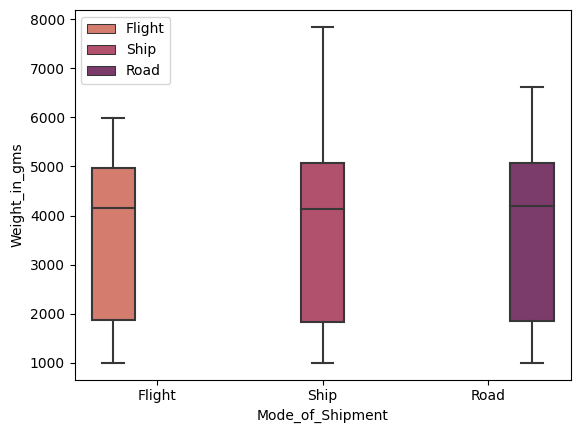

In [379]:
x = [df[df["Mode_of_Shipment"] == "Flight"]["Weight_in_gms"],df[df["Mode_of_Shipment"] == "Road"]["Weight_in_gms"],df[df["Mode_of_Shipment"] == "Ship"]["Weight_in_gms"]]

ax = sns.boxplot(data = df,x = df["Mode_of_Shipment"],y= df["Weight_in_gms"],hue =df["Mode_of_Shipment"], palette="flare")

# Set the color of the median lines
plt.legend(loc = "upper left")


### Although there's not much difference in the mode of shipment based on weight but it seems that company tends to ship packages with higher weights via "Ship" mode and as seen previously, they have almost similar conversion of packages reaching on time as that of `"Flight Mode"`

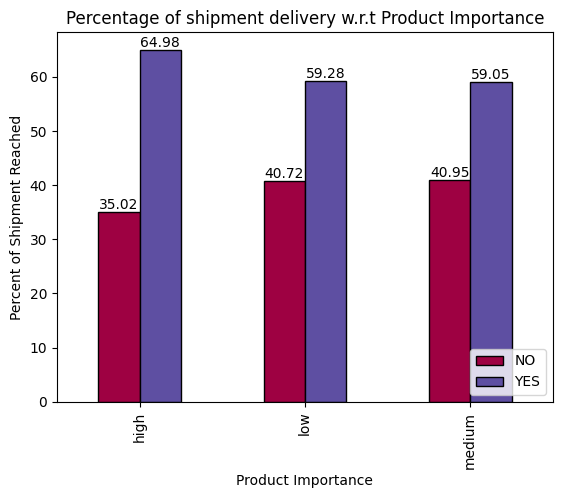

In [380]:
grouped = ((df.groupby(["Product_importance","Reached.on.Time_Y.N"])["Reached.on.Time_Y.N"].count()/df.groupby(["Product_importance"])["Reached.on.Time_Y.N"].count()*100)).unstack(fill_value=0)

# plot the grouped dataframe as a stacked bar chart
ax = grouped.plot(kind='bar', stacked=False,colormap = "Spectral",edgecolor = "black")

# set the x-axis label
ax.set_xlabel('Product Importance')

# set the y-axis label
ax.set_ylabel('Percent of Shipment Reached')

plt.legend(labels = ["No","Yes"])

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



plt.legend(loc = "lower right",labels = ["NO","YES"])
plt.title("Percentage of shipment delivery w.r.t Product Importance")
# show the plot
plt.show()




**There are instances where high product importance actually increases the count of shipment being reached on time !!**

## We will check how is the conversion of shipment received on time or not is affected by customer rating

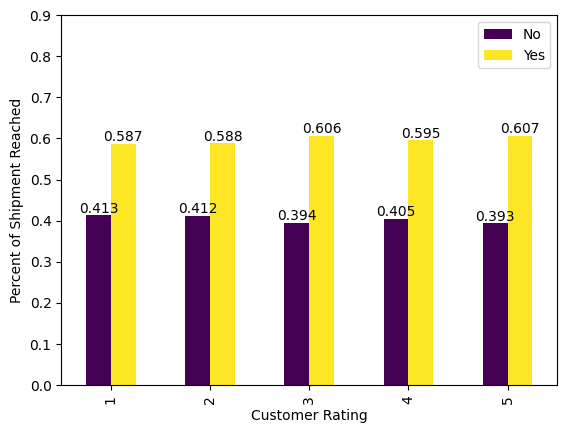

In [381]:
grouped = (df.groupby(["Customer_rating","Reached.on.Time_Y.N"])["Reached.on.Time_Y.N"].count()/df.groupby(["Customer_rating"])["Reached.on.Time_Y.N"].count()).unstack(fill_value=0)

# plot the grouped dataframe as a stacked bar chart
ax = grouped.plot(kind='bar', stacked=False,colormap = "viridis")

# set the x-axis label
ax.set_xlabel('Customer Rating')

# set the y-axis label
ax.set_ylabel('Percent of Shipment Reached')

plt.yticks([i*0.01 for i in range(0,100,10)])

plt.legend(labels = ["No","Yes"])

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#### Again not a major differentiator when it comes to Customer Rating

In [382]:
cols = df.columns.groupby(df.dtypes)
cols

{int64: ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N'], object: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']}

In [383]:
if df.isin(["?"]).any().any():
    print("Value 4 exists in the DataFrame")
else:
    print("Value 4 does not exist in the DataFrame")

Value 4 does not exist in the DataFrame


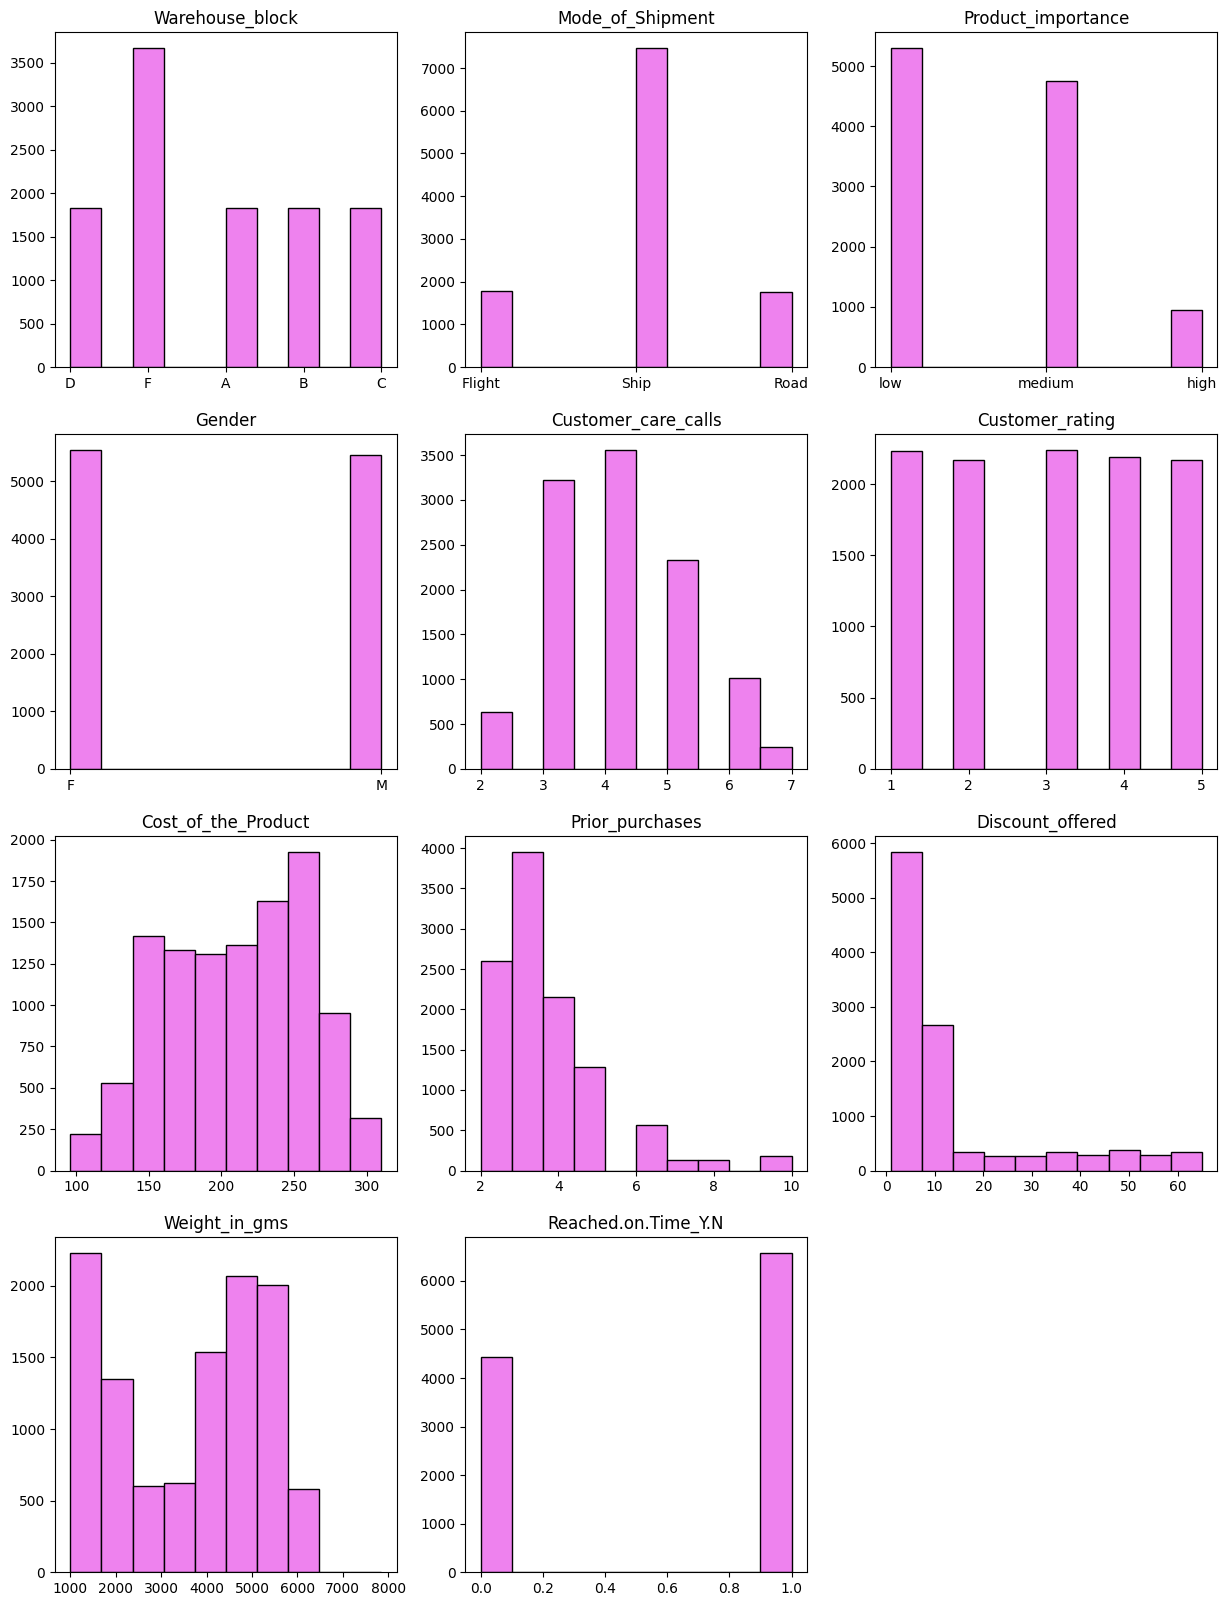

In [384]:

cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N']
fig = plt.figure(figsize=(15, 20))

for i in range(len(cols)):
  ax = fig.add_subplot(4, 3, i + 1)
  ax.hist(df[cols[i]],edgecolor = "black",color = "violet")
  ax.set_title(cols[i])
  

In [385]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.20,random_state = 20)
for train_index,test_index in split.split(np.zeros(len(df)),np.array(df["Reached.on.Time_Y.N"])):
    train = df.loc[train_index]
    test = df.loc[test_index]


In [386]:
train.rename(columns = {"Reached.on.Time_Y.N":"reached_ontime"},inplace=True)
test.rename(columns = {"Reached.on.Time_Y.N":"reached_ontime"},inplace=True)
test.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,reached_ontime
6652,C,Ship,3,4,235,2,low,F,10,4575,0
8343,B,Road,4,5,219,5,low,M,2,1260,0
1398,D,Ship,6,3,213,3,low,M,17,1656,1
9799,F,Ship,4,2,170,2,low,M,3,4299,0
7716,D,Ship,6,2,306,4,low,F,1,1815,1


In [387]:
xtrain = train.drop("reached_ontime",axis = 1)
ytrain = train["reached_ontime"]

xtest = test.drop("reached_ontime",axis = 1)
ytest = test["reached_ontime"]

In [388]:
ordi = ['Product_importance', 'Gender']
onehot = ['Warehouse_block', 'Mode_of_Shipment']

cols = ColumnTransformer([("ordi",OrdinalEncoder(),ordi),
                         ("onehot",OneHotEncoder(),onehot)],remainder="passthrough",verbose_feature_names_out=False)
                         
xtrain = cols.fit_transform(xtrain)
print(xtrain)


[[1.000e+00 1.000e+00 0.000e+00 ... 4.000e+00 3.000e+00 5.295e+03]
 [2.000e+00 1.000e+00 0.000e+00 ... 5.000e+00 4.400e+01 1.269e+03]
 [1.000e+00 0.000e+00 0.000e+00 ... 5.000e+00 9.000e+00 1.716e+03]
 ...
 [2.000e+00 0.000e+00 0.000e+00 ... 4.000e+00 2.000e+00 4.133e+03]
 [2.000e+00 1.000e+00 0.000e+00 ... 4.000e+00 7.000e+00 1.813e+03]
 [1.000e+00 1.000e+00 0.000e+00 ... 5.000e+00 6.000e+00 1.119e+03]]


In [389]:
std = StandardScaler()
xtrain = std.fit_transform(xtrain)
xtrain

array([[-0.55252868,  1.0042139 , -0.44840239, ...,  0.28334156,
        -0.63794502,  1.01581625],
       [ 1.03730122,  1.0042139 , -0.44840239, ...,  0.93959911,
         1.90466567, -1.44955142],
       [-0.55252868, -0.99580378, -0.44840239, ...,  0.93959911,
        -0.26585565, -1.1758258 ],
       ...,
       [ 1.03730122, -0.99580378, -0.44840239, ...,  0.28334156,
        -0.69995991,  0.30425211],
       [ 1.03730122,  1.0042139 , -0.44840239, ...,  0.28334156,
        -0.38988544, -1.11642672],
       [-0.55252868,  1.0042139 , -0.44840239, ...,  0.93959911,
        -0.45190033, -1.54140565]])

In [240]:
score = cross_val_score(SGDClassifier(),xtrain,ytrain,cv = 5,scoring = "f1")

error = -1*score
error.mean()

-0.6780901871667924

In [241]:
score = cross_val_score(LogisticRegression(),xtrain,ytrain,cv = 5,scoring = "f1")

error = -1*score
error.mean()

-0.6902358904990551

In [242]:
score = cross_val_score(SVC(),xtrain,ytrain,cv = 5,scoring = "f1")

error = -1*score
error.mean()

-0.6716429192651188

In [243]:
score = cross_val_score(RandomForestClassifier(),xtrain,ytrain,cv = 5,scoring = "f1")

error = -1*score
error.mean()

-0.6928709021320925

In [244]:
score = cross_val_score(MLPClassifier(),xtrain,ytrain,cv = 5,scoring = "f1")

error = -1*score
error.mean()

-0.6882535122102379

In [245]:
mlp = MLPClassifier()
mlp.fit(xtrain,ytrain)

ypred_mlp = mlp.predict(xtrain)

In [246]:
score = cross_val_score(BernoulliNB(),xtrain,ytrain,cv = 5,scoring = "f1")

error = -1*score
error.mean()

-0.6788660762946952

In [247]:
score = cross_val_score(KNeighborsClassifier(),xtrain,ytrain,cv = 5,scoring = "f1")

error = -1*score
error.mean()

-0.6838248210492587

We understood that out of all the models that we have applied SVC() was the worst performing one, so we will try to finetune other models and see from which of the models, we find the best score for our data

### Using SGDClassifier

In [248]:
param = {"max_iter":[1000,1500,2000,500],
        "eta0":[0,0.1,1,10,0.01],
        "tol" :[0.1,0.01,0.001],
        "learning_rate" :["constant","optimal","invscaling"]}

gs_sgd = GridSearchCV(SGDClassifier(early_stopping=True,random_state = 20),param_grid= param,cv = 5,scoring = 'f1')

gs_sgd.fit(xtrain,ytrain)

gs_sgd.best_estimator_

SGDClassifier(early_stopping=True, eta0=0.01, learning_rate='invscaling',
              random_state=20, tol=0.1)

In [249]:
gs_sgd.best_estimator_.fit(xtrain,ytrain)
ypred_sgd = gs_sgd.best_estimator_.predict(xtrain)

In [250]:
from sklearn.metrics import classification_report
print(classification_report(ytrain,ypred_sgd))

              precision    recall  f1-score   support

           0       0.56      0.75      0.64      3549
           1       0.78      0.61      0.68      5250

    accuracy                           0.66      8799
   macro avg       0.67      0.68      0.66      8799
weighted avg       0.69      0.66      0.67      8799



# Using LogisticRegression

In [260]:
param = {"penalty" :["l1","l2","elasticnet"],
        "tol":[0.1,0.001,0.01],
        "C" :[1,0.1,10,0.01],
        "solver" :["lbfgs","saga"],
        "max_iter" : [100,1000,2000]}

gs_lr = GridSearchCV(LogisticRegression(random_state = 20),param_grid = param,cv =5,scoring ='f1')

gs_lr.fit(xtrain,ytrain)

gs_lr.best_estimator_

LogisticRegression(C=0.01, penalty='l1', random_state=20, solver='saga',
                   tol=0.01)

In [261]:
gs_lr.best_estimator_.fit(xtrain,ytrain)
ypred_lr = gs_lr.best_estimator_.predict(xtrain)

In [262]:
print(classification_report(ytrain,ypred_lr))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      3549
           1       0.69      0.70      0.70      5250

    accuracy                           0.64      8799
   macro avg       0.62      0.62      0.62      8799
weighted avg       0.64      0.64      0.64      8799



In [230]:
param = {"n_estimators":[10,20],
        "bootstrap":[True,False],
        "max_depth": [None, 5, 10, 20, 30],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

gs_rf = GridSearchCV(RandomForestClassifier(max_features = None,random_state = 20),param_grid = param,cv =5,scoring ='f1')

gs_rf.fit(xtrain,ytrain)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features=None,
                                              random_state=20),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [10, 20]},
             scoring='f1')

In [231]:
gs_rf.best_estimator_

RandomForestClassifier(max_features=None, min_samples_split=6, n_estimators=10,
                       random_state=20)

In [232]:
gs_rf.best_estimator_.fit(xtrain,ytrain)
ypred_rf = gs_rf.best_estimator_.predict(xtrain)

In [251]:
print(classification_report(ytrain,ypred_rf))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3549
           1       0.98      0.97      0.98      5250

    accuracy                           0.97      8799
   macro avg       0.97      0.97      0.97      8799
weighted avg       0.97      0.97      0.97      8799



In [252]:
param = {"n_neighbors": [1,2,3,4,5,6,8,9,10],
        "weights": ['uniform', 'distance'],
        "metric":["euclidean", "manhattan", "chebyshev","minkowski"]}

gs_knn = GridSearchCV(KNeighborsClassifier(algorithm = "ball_tree"),param_grid = param,cv = 5,scoring = 'f1')

gs_knn.fit(xtrain,ytrain)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(algorithm='ball_tree'),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [253]:
gs_knn.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', metric='chebyshev', n_neighbors=8,
                     weights='distance')

In [254]:
gs_knn.best_estimator_.fit(xtrain,ytrain)
ypred_knn = gs_knn.best_estimator_.predict(xtrain)

In [255]:
print(classification_report(ytrain,ypred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3549
           1       1.00      1.00      1.00      5250

    accuracy                           1.00      8799
   macro avg       1.00      1.00      1.00      8799
weighted avg       1.00      1.00      1.00      8799



In [263]:
ypred = [ypred_sgd,ypred_lr,ypred_rf,ypred_knn,ypred_mlp]


estimator = ["SGDClassifier","LogisticRegression","RandomForest","KNNClassifier","MLPClassifier"]
from sklearn.metrics import f1_score,precision_score,recall_score,precision_recall_curve

F1 score for SGDClassifier : 0.683
Precision score for SGDClassifier : 0.781
Recall score for SGDClassifier : 0.607
----------------------------------------------------------------------------------------------------
F1 score for LogisticRegression : 0.696
Precision score for LogisticRegression : 0.695
Recall score for LogisticRegression : 0.698
----------------------------------------------------------------------------------------------------
F1 score for RandomForest : 0.977
Precision score for RandomForest : 0.982
Recall score for RandomForest : 0.972
----------------------------------------------------------------------------------------------------
F1 score for KNNClassifier : 1.000
Precision score for KNNClassifier : 1.000
Recall score for KNNClassifier : 1.000
----------------------------------------------------------------------------------------------------
F1 score for MLPClassifier : 0.779
Precision score for MLPClassifier : 0.821
Recall score for MLPClassifier : 0.741
----

<Figure size 1000x1200 with 0 Axes>

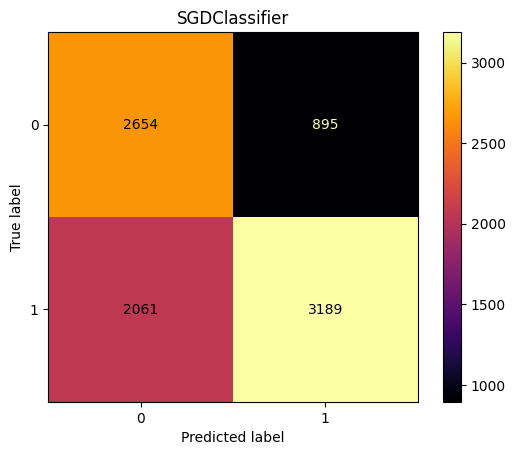

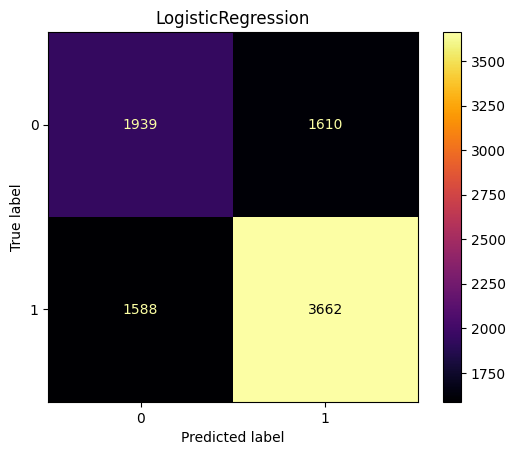

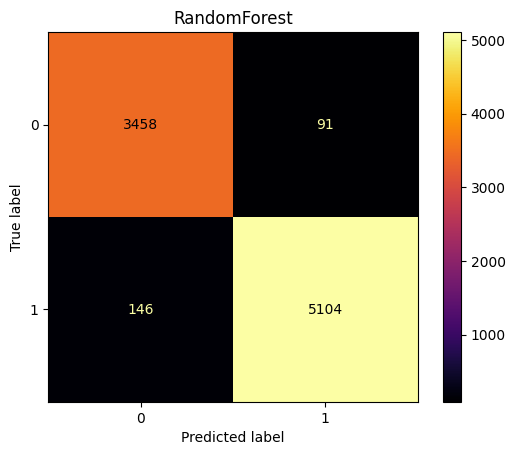

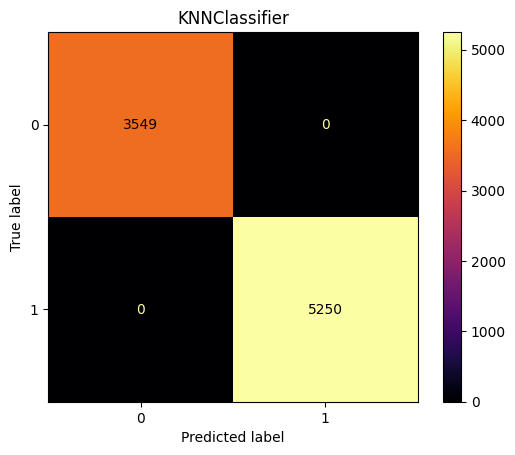

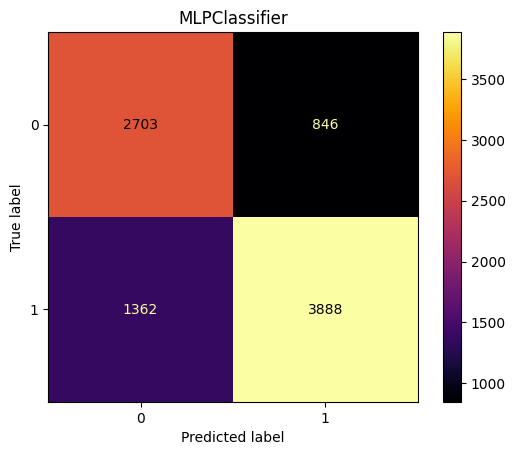

In [392]:
from sklearn.metrics import ConfusionMatrixDisplay

def conf(yt,yp,estimator):
    fig = plt.figure(figsize = (10,12))
    k = 0
    for k,i in enumerate(yp):
        #corr = pd.DataFrame([np.array(yt),np.array(i)]).corr()
        #sns.heatmap(corr)
        ConfusionMatrixDisplay.from_predictions(np.array(yt),np.array(i),cmap = "inferno")
        plt.title(estimator[k])
        print(f"F1 score for {estimator[k]} : {f1_score(np.array(yt),np.array(i)):.3f}")
        print(f"Precision score for {estimator[k]} : {precision_score(np.array(yt),np.array(i)):.3f}")
        print(f"Recall score for {estimator[k]} : {recall_score(np.array(yt),np.array(i)):.3f}")
        print("-"*100)
        


conf(ytrain,ypred,estimator)

> **From above metrics, we found that Random Forest classifier is the best model although KNN gives better score but it seems to be an overfitted model which we should avoid or tune its parameter for better results** 

#### Let's further apply these models on test set for understanding how aptly fit these these models are !!

## Preprocessing TEST DATA

In [390]:
xtest = cols.transform(xtest)
print(xtest)

xtest = std.transform(xtest)
xtest

[[1.000e+00 0.000e+00 0.000e+00 ... 2.000e+00 1.000e+01 4.575e+03]
 [1.000e+00 1.000e+00 0.000e+00 ... 5.000e+00 2.000e+00 1.260e+03]
 [1.000e+00 1.000e+00 0.000e+00 ... 3.000e+00 1.700e+01 1.656e+03]
 ...
 [2.000e+00 0.000e+00 0.000e+00 ... 4.000e+00 8.000e+00 4.357e+03]
 [1.000e+00 1.000e+00 0.000e+00 ... 6.000e+00 8.000e+00 1.932e+03]
 [1.000e+00 1.000e+00 0.000e+00 ... 3.000e+00 1.600e+01 1.563e+03]]


array([[-0.55252868, -0.99580378, -0.44840239, ..., -1.02917353,
        -0.20384075,  0.57491593],
       [-0.55252868,  1.0042139 , -0.44840239, ...,  0.93959911,
        -0.69995991, -1.45506267],
       [-0.55252868,  1.0042139 , -0.44840239, ..., -0.37291598,
         0.23026351, -1.21256749],
       ...,
       [ 1.03730122, -0.99580378, -0.44840239, ...,  0.28334156,
        -0.32787054,  0.4414211 ],
       [-0.55252868,  1.0042139 , -0.44840239, ...,  1.59585666,
        -0.32787054, -1.0435557 ],
       [-0.55252868,  1.0042139 , -0.44840239, ..., -0.37291598,
         0.16824862, -1.26951712]])

F1 score for Random Forest : 0.745
Precision score for Random Forest : 0.597
Recall score for Random Forest : 0.989
----------------------------------------------------------------------------------------------------


<Figure size 1000x1200 with 0 Axes>

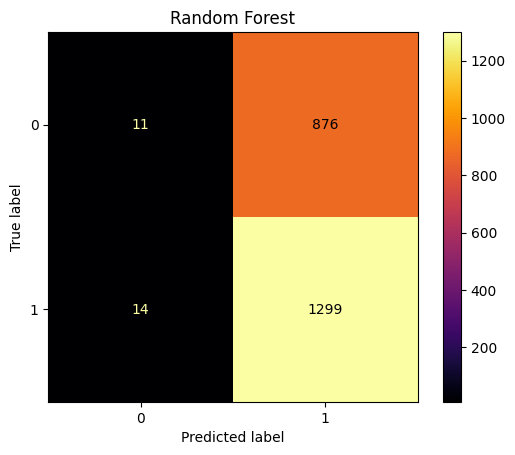

In [393]:
ytest_pred = gs_rf.best_estimator_.predict(xtest)

conf(ytest,[ytest_pred],["Random Forest"])

F1 score for KNN : 0.696
Precision score for KNN : 0.700
Recall score for KNN : 0.692
----------------------------------------------------------------------------------------------------


<Figure size 1000x1200 with 0 Axes>

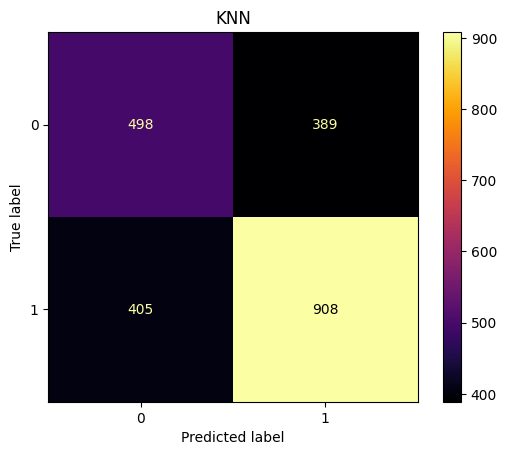

In [394]:
ytest_predknn = gs_knn.best_estimator_.predict(xtest)
conf(ytest,[ytest_predknn],["KNN"])

**Both models have their own Pros & Cons, for example** : 
1. In Random Forest, we can see that we are getting a low precision score but a very high recall and an in-between F1 score, we can use the precision-recall curve to get a balance of these two metrics so that our model might produce better results BUT it is always up to you whether you are comfortable with high recall, high precision or want a balance of both as it depends on problem we want to solve.<br><br>
2. In KNN the model seems to be overfitted when checked on training data and have average scores for all three metrics that we have checked which might not be a good option when it comes to a real world scenario !!